In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("Utils")

from plot_track import plot_track
from cartesian_to_curvilinear_for_one import pose_to_curvi
import yaml
from matplotlib.widgets import Button


In [2]:
data = pd.read_feather('Obtained Model Data/all_trajectories_filtered.feather')
data = data.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
data = data.to_dict()

/tmp/ipykernel_15247/2925515577.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


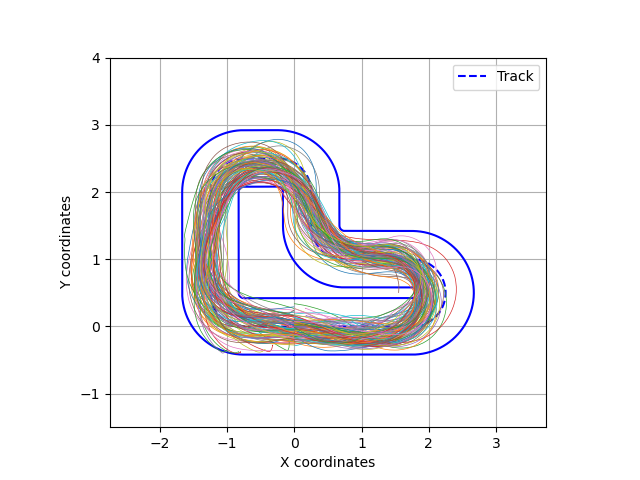

In [3]:
%matplotlib widget

data_reset = data
with open("la_track.yaml", "r") as file:
    track_shape_data = yaml.safe_load(file)

fig, ax = plt.subplots()
plot_track(fig, ax, track_shape_data)

for traj in data:
    plt.plot(data[traj]['x'], data[traj]['y'], linewidth = 0.5)

plt.savefig(f'figures/expert_trajectories.svg', format='svg')  

#     data[traj]["omega"] = np.clip(data[traj]["omega"], -4, 4)

# # # Save the DataFrame to Feather without modifying the original index
# clipped_dataframe = pd.DataFrame(data)

# # Save the DataFrame to Feather format
# clipped_dataframe.to_feather('Obtained Model Data/all_trajectories_omega_clipped.feather')



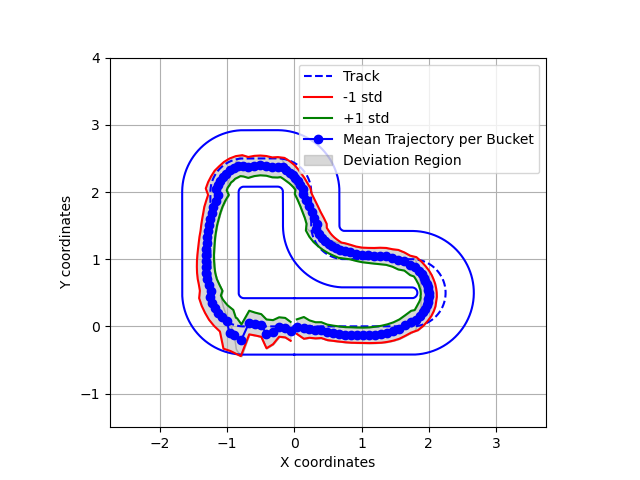

In [4]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

n_buckets = 120  # Number of buckets to divide s into (0.0-0.1, 0.1-0.2, ..., 0.9-1.0)
number_of_std  = 1 

bucket_edges = np.linspace(0, 10.71, n_buckets + 1) # start and ends of buckets
use_mean = True

# to concatenate the trajectories initialize the lists for all variables
all_s = []
all_x = []
all_y = []
all_e = []
all_dtheta = []
all_vx = []
all_vy = []
all_omega = []
all_steering = []  # Added for steering
all_throttle = []  # Added for throttle

# Concatenate all trajectories, including throttle
for traj in data:
    s = np.array(data[traj]['s']) 
    x = np.array(data[traj]['x']) 
    y = np.array(data[traj]['y']) 
    dtheta = np.array(data[traj]['dtheta']) 
    vx = np.array(data[traj]['vx'])  
    vy = np.array(data[traj]['vy'])  
    e = np.array(data[traj]['e']) 
    omega = np.array(data[traj]['omega']) 
    steering = np.array(data[traj]['steering'])  # Added for steering
    throttle = np.array(data[traj]['throttle'])  # Added for throttle

    all_s.append(s)
    all_x.append(x)
    all_y.append(y)
    all_dtheta.append(dtheta)
    all_vx.append(vx)
    all_vy.append(vy)
    all_e.append(e)
    all_omega.append(omega)
    all_steering.append(steering)  # Added for steering
    all_throttle.append(throttle)  # Added for throttle

all_s = np.concatenate(all_s)
all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_dtheta = np.concatenate(all_dtheta)
all_vx = np.concatenate(all_vx)
all_vy = np.concatenate(all_vy)
all_e = np.concatenate(all_e)
all_omega = np.concatenate(all_omega)
all_steering = np.concatenate(all_steering)  # Added for steering
all_throttle = np.concatenate(all_throttle)  # Added for throttle

# Sort all of them
sorted_indices = np.argsort(all_s)
s_sorted = all_s[sorted_indices]
x_sorted = all_x[sorted_indices]
y_sorted = all_y[sorted_indices]
dtheta_sorted = all_dtheta[sorted_indices]
vx_sorted = all_vx[sorted_indices]
vy_sorted = all_vy[sorted_indices]
e_sorted = all_e[sorted_indices]
omega_sorted = all_omega[sorted_indices]
steering_sorted = all_steering[sorted_indices]  # Added for steering
throttle_sorted = all_throttle[sorted_indices]  # Added for throttle

# Initialize means and std lists for all buckets
mean_s_per_bucket = []
std_s_per_bucket = []
mean_x_per_bucket = []
mean_y_per_bucket = []
std_x_per_bucket = []
std_y_per_bucket = []
mean_e_per_bucket = []
std_e_per_bucket = []
mean_dtheta_per_bucket = []
std_dtheta_per_bucket = []
mean_vx_per_bucket = []
std_vx_per_bucket = []
mean_vy_per_bucket = []
std_vy_per_bucket = []
mean_omega_per_bucket = []
std_omega_per_bucket = []
mean_steering_per_bucket = []  # Added for steering
std_steering_per_bucket = []  # Added for steering
mean_throttle_per_bucket = []  # Added for throttle
std_throttle_per_bucket = []  # Added for throttle
bucket_centers = []

cov_matrices_e_dtheta = []
cov_matrices_e_omega = []
cov_matrices_dtheta_omega = []
cov_matrices_omega_steering = []  # Added for omega and steering covariance
cov_matrices_s_throttle = []  # Added for covariance between s and throttle

# Add the means, stds, and covariance matrices for individual buckets
for i in range(n_buckets):
    bucket_start = bucket_edges[i]
    bucket_end = bucket_edges[i + 1]

    in_bucket = (s_sorted >= bucket_start) & (s_sorted < bucket_end)

    bucket_s = s_sorted[in_bucket]
    bucket_x = x_sorted[in_bucket]
    bucket_y = y_sorted[in_bucket]
    bucket_dtheta = dtheta_sorted[in_bucket]
    bucket_vx = vx_sorted[in_bucket]
    bucket_vy = vy_sorted[in_bucket]
    bucket_e = e_sorted[in_bucket]
    bucket_omega = omega_sorted[in_bucket]
    bucket_steering = steering_sorted[in_bucket]  # Added for steering
    bucket_throttle = throttle_sorted[in_bucket]  # Added for throttle

    if len(bucket_x) > 0:  # Ensure there are enough data points

        if use_mean:
            mean_s = np.mean(bucket_s)
            std_s = np.std(bucket_s)
            mean_x = np.mean(bucket_x)
            mean_y = np.mean(bucket_y)
            std_x = np.std(bucket_x)
            std_y = np.std(bucket_y)
            mean_dtheta = np.mean(bucket_dtheta)
            std_dtheta = np.std(bucket_dtheta)
            mean_vx = np.mean(bucket_vx)
            std_vx = np.std(bucket_vx)
            mean_vy = np.mean(bucket_vy)
            std_vy = np.std(bucket_vy)
            mean_e = np.mean(bucket_e)
            std_e = np.std(bucket_e)
            mean_omega = np.mean(bucket_omega)
            std_omega = np.std(bucket_omega)
            mean_steering = np.mean(bucket_steering)  # Added for steering
            std_steering = np.std(bucket_steering)  # Added for steering
            mean_throttle = np.mean(bucket_throttle)  # Added for throttle
            std_throttle = np.std(bucket_throttle)  # Added for throttle
        else:
            mean_s = np.median(bucket_s)
            std_s = np.std(bucket_s)
            mean_x = np.median(bucket_x)
            mean_y = np.median(bucket_y)
            std_x = np.std(bucket_x)
            std_y = np.std(bucket_y)
            mean_dtheta = np.median(bucket_dtheta)
            std_dtheta = np.std(bucket_dtheta)
            mean_vx = np.median(bucket_vx)
            std_vx = np.std(bucket_vx)
            mean_vy = np.median(bucket_vy)
            std_vy = np.std(bucket_vy)
            mean_e = np.median(bucket_e)
            std_e = np.std(bucket_e)
            mean_omega = np.median(bucket_omega)
            std_omega = np.std(bucket_omega)
            mean_steering = np.median(bucket_steering)  # Added for steering
            std_steering = np.std(bucket_steering)  # Added for steering
            mean_throttle = np.median(bucket_throttle)  # Added for throttle
            std_throttle = np.std(bucket_throttle)  # Added for throttle

        # Covariance matrices
        cov_matrix_e_dtheta = np.cov(bucket_e, bucket_dtheta)
        cov_matrix_e_omega = np.cov(bucket_e, bucket_omega)
        cov_matrix_dtheta_omega = np.cov(bucket_dtheta, bucket_omega)
        cov_matrix_omega_steering = np.cov(bucket_omega, bucket_steering)  # Covariance between omega and steering
        cov_matrix_s_throttle = np.cov(bucket_s, bucket_throttle)  # Covariance between s and throttle

        # Append results to the lists#
        mean_s_per_bucket.append(mean_s)
        std_s_per_bucket.append(std_s)
        mean_x_per_bucket.append(mean_x)
        mean_y_per_bucket.append(mean_y)
        std_x_per_bucket.append(std_x)
        std_y_per_bucket.append(std_y)
        mean_dtheta_per_bucket.append(mean_dtheta)
        std_dtheta_per_bucket.append(std_dtheta)
        mean_vx_per_bucket.append(mean_vx)
        std_vx_per_bucket.append(std_vx)
        mean_vy_per_bucket.append(mean_vy)
        std_vy_per_bucket.append(std_vy)
        mean_e_per_bucket.append(mean_e)
        std_e_per_bucket.append(std_e)
        mean_omega_per_bucket.append(mean_omega)
        std_omega_per_bucket.append(std_omega)
        mean_steering_per_bucket.append(mean_steering)  # Added for steering
        std_steering_per_bucket.append(std_steering)  # Added for steering
        mean_throttle_per_bucket.append(mean_throttle)  # Added for throttle
        std_throttle_per_bucket.append(std_throttle)  # Added for throttle
        bucket_centers.append((bucket_start + bucket_end) / 2)

        # Append covariance matrices
        cov_matrices_e_dtheta.append(cov_matrix_e_dtheta)
        cov_matrices_e_omega.append(cov_matrix_e_omega)
        cov_matrices_dtheta_omega.append(cov_matrix_dtheta_omega)
        cov_matrices_omega_steering.append(cov_matrix_omega_steering)  # Added for omega and steering covariance
        cov_matrices_s_throttle.append(cov_matrix_s_throttle)  # Added for s and throttle covariance

# Convert lists to arrays
mean_s_per_bucket = np.array(mean_s_per_bucket)
std_s_per_bucket = np.array(std_s_per_bucket)
mean_x_per_bucket = np.array(mean_x_per_bucket)
mean_y_per_bucket = np.array(mean_y_per_bucket)
std_x_per_bucket = np.array(std_x_per_bucket)
std_y_per_bucket = np.array(std_y_per_bucket)
mean_dtheta_per_bucket = np.array(mean_dtheta_per_bucket)
std_dtheta_per_bucket = np.array(std_dtheta_per_bucket)
mean_vx_per_bucket = np.array(mean_vx_per_bucket)
std_vx_per_bucket = np.array(std_vx_per_bucket)
mean_vy_per_bucket = np.array(mean_vy_per_bucket)
std_vy_per_bucket = np.array(std_vy_per_bucket)
mean_e_per_bucket = np.array(mean_e_per_bucket)
std_e_per_bucket = np.array(std_e_per_bucket)
mean_omega_per_bucket = np.array(mean_omega_per_bucket)
std_omega_per_bucket = np.array(std_omega_per_bucket)
mean_steering_per_bucket = np.array(mean_steering_per_bucket)  # Added for steering
std_steering_per_bucket = np.array(std_steering_per_bucket)  # Added for steering
mean_throttle_per_bucket = np.array(mean_throttle_per_bucket)  # Added for throttle
std_throttle_per_bucket = np.array(std_throttle_per_bucket)  # Added for throttle
bucket_centers = np.array(bucket_centers)

cov_matrices_e_dtheta = np.array(cov_matrices_e_dtheta)
cov_matrices_e_dtheta_flat = [cov_matrix.flatten() for cov_matrix in cov_matrices_e_dtheta]

cov_matrices_e_omega = np.array(cov_matrices_e_omega)
cov_matrices_e_omega_flat = [cov_matrix.flatten() for cov_matrix in cov_matrices_e_omega]

cov_matrices_dtheta_omega = np.array(cov_matrices_dtheta_omega)
cov_matrices_dtheta_omega_flat = [cov_matrix.flatten() for cov_matrix in cov_matrices_dtheta_omega]

cov_matrices_omega_steering = np.array(cov_matrices_omega_steering)
cov_matrices_omega_steering_flat = [cov_matrix.flatten() for cov_matrix in cov_matrices_omega_steering]  # Added for omega and steering

cov_matrices_s_throttle = np.array(cov_matrices_s_throttle)
cov_matrices_s_throttle_flat = [cov_matrix.flatten() for cov_matrix in cov_matrices_s_throttle]  # Added for s and throttle covariance


# plot them
fig, ax = plt.subplots()
plot_track(fig, ax, track_shape_data)

x_upper = []
x_lower = []
y_upper = []
y_lower = []
x_mean_list = []
y_mean_list = []


for i in range(n_buckets):

    s = bucket_centers[i]

    idx = np.argmin(np.abs(track_shape_data["track"]["arcLength"] - s))

    theta = track_shape_data["track"]["tangentAngle"][idx]

    mean_e = mean_e_per_bucket[i]

    normal_vector = np.array([-np.sin(theta), np.cos(theta)])

    lateral_std = std_e_per_bucket[i]

    displacement = normal_vector * lateral_std

    # x_mean = track_shape_data["track"]["xCoords"][idx] - track_shape_data["track"]["x_init"]  + (mean_e * normal_vector)[0]
    # y_mean = track_shape_data["track"]["yCoords"][idx] - track_shape_data["track"]["y_init"]  + (mean_e * normal_vector)[0]

    x_mean = mean_x_per_bucket[i] 
    y_mean = mean_y_per_bucket[i]

    x_mean_list.append(x_mean)
    y_mean_list.append(y_mean)

    x_upper.append(x_mean + number_of_std * displacement[0]) 
    y_upper.append(y_mean + number_of_std *displacement[1]) 
    x_lower.append(x_mean - number_of_std *displacement[0]) 
    y_lower.append(y_mean - number_of_std *displacement[1]) 

ax.plot(x_lower, y_lower, color='red', label=f'-{number_of_std} std')
ax.plot(x_upper, y_upper, color='green', label=f'+{number_of_std} std')

ax.plot(mean_x_per_bucket, mean_y_per_bucket, color='blue', label='Mean Trajectory per Bucket', marker="o")

ax.fill_betweenx(y_lower, x_lower, x_upper, color='gray', alpha=0.3, label='Deviation Region')
ax.fill_between(x_upper, y_upper, y_lower, color='gray', alpha=0.3)


ax.legend()
plt.show()

plt.savefig(f'figures/mean_trajectory_expert.svg', format='svg')  


# create the dataframes
bucket_data_mean_std = pd.DataFrame({
    's': bucket_centers,
    'mean_s': mean_s_per_bucket,
    'std_s': std_s_per_bucket,
    'mean_x': mean_x_per_bucket,
    'mean_y': mean_y_per_bucket,
    'std_x': std_x_per_bucket,
    'std_y': std_y_per_bucket,
    'mean_dtheta': mean_dtheta_per_bucket,
    'std_dtheta': std_dtheta_per_bucket,
    'mean_vx': mean_vx_per_bucket,
    'std_vx': std_vx_per_bucket,
    'mean_vy': mean_vy_per_bucket,
    'std_vy': std_vy_per_bucket,
    "mean_e": mean_e_per_bucket,
    "std_e":std_e_per_bucket,
    "mean_omega":mean_omega_per_bucket,
    "std_omega": std_omega_per_bucket,
    "mean_steering":mean_steering_per_bucket,
    "std_steering":std_steering_per_bucket,
    "mean_throttle":mean_throttle_per_bucket,
    "std_throttle":std_throttle_per_bucket,
    "cov_e_dtheta": cov_matrices_e_dtheta_flat, 
    "cov_e_omega":cov_matrices_e_omega_flat,
    "cov_dtheta_omega": cov_matrices_dtheta_omega_flat,
    "cov_omega_steering": cov_matrices_omega_steering_flat,
    "cov_s_throttle": cov_matrices_s_throttle_flat
})

# bucket_data_mean_std_df = pd.DataFrame(bucket_data_mean_std)

# bucket_data_mean_std_df.to_feather('Obtained Model Data/bucket_data_mean_std.feather')


mean_traj = {
    's': bucket_centers,
    'x': mean_x_per_bucket,
    'y': mean_y_per_bucket,
    'dtheta': mean_dtheta_per_bucket,
    'vx': mean_vx_per_bucket,
    'vy': mean_vy_per_bucket,
    'e': mean_e_per_bucket,
    "omega":mean_omega_per_bucket
}

mean_traj_df = pd.DataFrame(mean_traj)

# mean_traj_df.to_feather('mean_trajectory.feather')


outer_traj = {
    's': bucket_centers,
    'x': mean_x_per_bucket + std_x_per_bucket,
    'y': mean_y_per_bucket + std_y_per_bucket,
    'dtheta': mean_dtheta_per_bucket + std_dtheta_per_bucket,
    'vx': mean_vx_per_bucket + std_vx_per_bucket,
    'vy': mean_vy_per_bucket + std_vy_per_bucket,
    'e': mean_e_per_bucket + std_e_per_bucket,
    "omega": mean_omega_per_bucket + std_omega_per_bucket
}

inner_traj = {
    's': bucket_centers,
    'x': mean_x_per_bucket - std_x_per_bucket,
    'y': mean_y_per_bucket - std_y_per_bucket,
    'dtheta': mean_dtheta_per_bucket - std_dtheta_per_bucket,
    'vx': mean_vx_per_bucket - std_vx_per_bucket,
    'vy': mean_vy_per_bucket - std_vy_per_bucket,
    'e': mean_e_per_bucket - std_e_per_bucket,
    "omega": mean_omega_per_bucket - std_omega_per_bucket
}




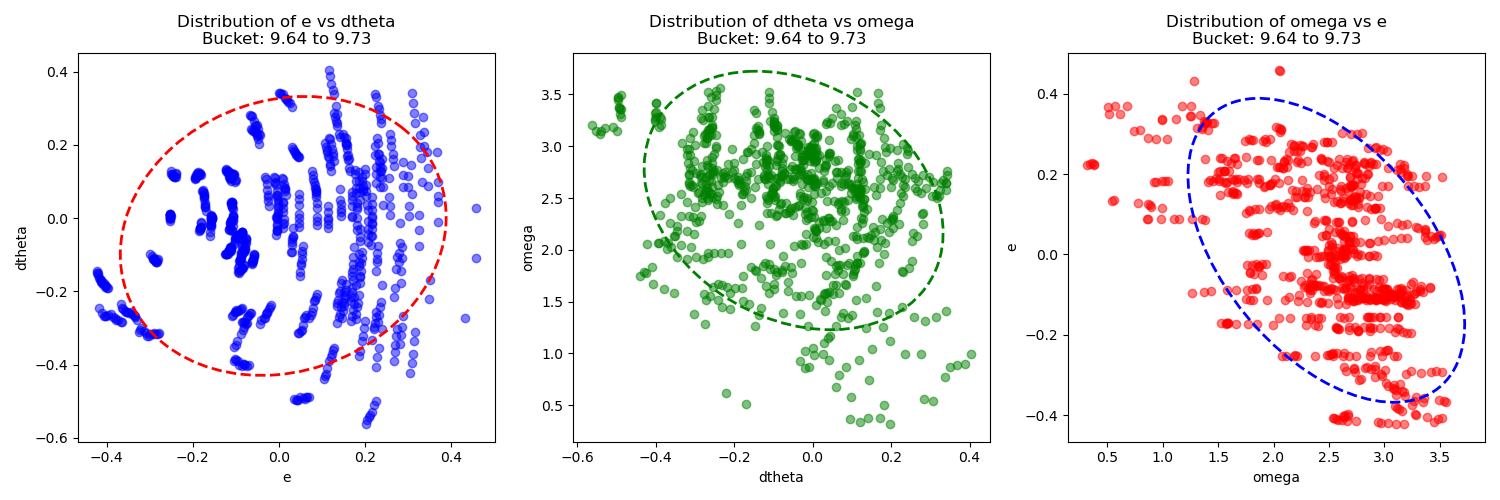

In [5]:
from matplotlib.patches import Ellipse

%matplotlib widget


random_bucket_index = np.random.choice(len(bucket_centers))

# Get the start and end of the current bucket
bucket_start = bucket_edges[random_bucket_index]
bucket_end = bucket_edges[random_bucket_index + 1]

# Filter the data to get the points within the bucket
in_bucket = (s_sorted >= bucket_start) & (s_sorted < bucket_end)
bucket_dtheta = dtheta_sorted[in_bucket]
bucket_e = e_sorted[in_bucket]
bucket_omega = omega_sorted[in_bucket]  # Assuming omega_sorted exists

# Compute covariance matrices for the three pairs of variables
cov_matrix_ed = np.cov(bucket_e, bucket_dtheta)
cov_matrix_do = np.cov(bucket_dtheta, bucket_omega)
cov_matrix_oe = np.cov(bucket_omega, bucket_e)

# Compute the eigenvalues and eigenvectors for each pair
eigvals_ed, eigvecs_ed = np.linalg.eig(cov_matrix_ed)
eigvals_do, eigvecs_do = np.linalg.eig(cov_matrix_do)
eigvals_oe, eigvecs_oe = np.linalg.eig(cov_matrix_oe)

# Calculate the standard deviations (square root of the eigenvalues)
stds_ed = np.sqrt(eigvals_ed)
stds_do = np.sqrt(eigvals_do)
stds_oe = np.sqrt(eigvals_oe)

# Compute the angles of the ellipses from the eigenvectors
angle_ed = np.arctan2(eigvecs_ed[1, 0], eigvecs_ed[0, 0]) * 180 / np.pi
angle_do = np.arctan2(eigvecs_do[1, 0], eigvecs_do[0, 0]) * 180 / np.pi
angle_oe = np.arctan2(eigvecs_oe[1, 0], eigvecs_oe[0, 0]) * 180 / np.pi

# Create the ellipses
ellipse_ed = Ellipse(xy=(np.mean(bucket_e), np.mean(bucket_dtheta)),
                     width=4 * stds_ed[0], height=4 * stds_ed[1],
                     angle=angle_ed, edgecolor='red', facecolor='none', linestyle='--', linewidth=2)

ellipse_do = Ellipse(xy=(np.mean(bucket_dtheta), np.mean(bucket_omega)),
                     width=4 * stds_do[0], height=4 * stds_do[1],
                     angle=angle_do, edgecolor='green', facecolor='none', linestyle='--', linewidth=2)

ellipse_oe = Ellipse(xy=(np.mean(bucket_omega), np.mean(bucket_e)),
                     width=4 * stds_oe[0], height=4 * stds_oe[1],
                     angle=angle_oe, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2)

# Create subplots for the 1x3 grid of ellipses
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for e vs dtheta
axes[0].scatter(bucket_e, bucket_dtheta, color='blue', alpha=0.5)
axes[0].add_patch(ellipse_ed)
axes[0].set_xlabel('e')
axes[0].set_ylabel('dtheta')
axes[0].set_title(f'Distribution of e vs dtheta\nBucket: {bucket_start:.2f} to {bucket_end:.2f}')

# Plot for dtheta vs omega
axes[1].scatter(bucket_dtheta, bucket_omega, color='green', alpha=0.5)
axes[1].add_patch(ellipse_do)
axes[1].set_xlabel('dtheta')
axes[1].set_ylabel('omega')
axes[1].set_title(f'Distribution of dtheta vs omega\nBucket: {bucket_start:.2f} to {bucket_end:.2f}')

# Plot for omega vs e
axes[2].scatter(bucket_omega, bucket_e, color='red', alpha=0.5)
axes[2].add_patch(ellipse_oe)
axes[2].set_xlabel('omega')
axes[2].set_ylabel('e')
axes[2].set_title(f'Distribution of omega vs e\nBucket: {bucket_start:.2f} to {bucket_end:.2f}')

plt.tight_layout()
plt.show()


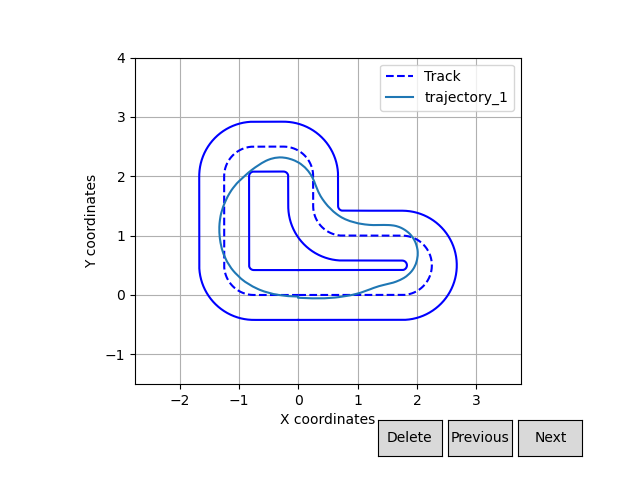

In [6]:
%matplotlib widget

# plot all trajectories one by one

data = data_reset

filtered_data = {key: value for key, value in data.items() if 's' in value and len(value['s']) > 0}

def update_trajectory(label):
    ax.clear()  # Clear the current plot
    plot_track(fig, ax, track_shape_data)  # Redraw the track shape
    if label in filtered_data:
        ax.plot(filtered_data[label]['x'], filtered_data[label]['y'], label=label)
    ax.legend()
    plt.draw()

class Index:
    def __init__(self, traj_labels):
        self.idx = 0
        self.traj_labels = traj_labels

    def next(self, event):
        self.idx = (self.idx + 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

    def prev(self, event):
        self.idx = (self.idx - 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

    def delete(self, event):
        """Delete the currently displayed trajectory."""
        traj_to_delete = self.traj_labels[self.idx]
        del filtered_data[traj_to_delete]  # Remove the trajectory from the filtered data
        self.traj_labels = list(filtered_data.keys())  # Update the labels list
        if self.traj_labels:  # Check if there are any remaining trajectories
            self.idx = self.idx % len(self.traj_labels)  # Adjust index if necessary
            update_trajectory(self.traj_labels[self.idx])
        else:
            ax.clear()
            plot_track(fig, ax, track_shape_data)
            ax.legend()
            plt.draw()  # Redraw the plot if no trajectories remain


# Create the figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)

# Draw the track shape
plot_track(fig, ax, track_shape_data)

# Initial trajectory plot
initial_traj = list(filtered_data.keys())[0]
ax.plot(filtered_data[initial_traj]['x'], filtered_data[initial_traj]['y'], label=initial_traj)
ax.legend()

# Create button axes for navigation and deletion
axprev = plt.axes([0.7, 0.05, 0.1, 0.075]) 
axnext = plt.axes([0.81, 0.05, 0.1, 0.075]) 
axdelete = plt.axes([0.59, 0.05, 0.1, 0.075])  # Position for the delete button

# List of trajectory labels
traj_labels = list(filtered_data.keys())

# Create the callback instance
callback = Index(traj_labels)

# Create Next and Previous buttons
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)

bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

# Create Delete button
bdelete = Button(axdelete, 'Delete')
bdelete.on_clicked(callback.delete)

# Show the plot
plt.show()

In [30]:
# # Save the DataFrame to Feather without modifying the original index
# filtered_all_traj_df = pd.DataFrame(filtered_data)

# # Save the DataFrame to Feather format
# filtered_all_traj_df.to_feather('Obtained Model Data/all_trajectories_filtered.feather')



In [12]:
import yaml
import numpy as np

data = data_reset

# create added data in the same format as the filtered data and same type but all empty inside added_data
added_data = {key: {key: [] for key in value} for key, value in filtered_data.items()}

use_ellipsoids = False
vel_augmentation = False
points_per_data = 1
add_noise_to_omega = True

filtered_data_copy = filtered_data.copy()


def is_outside_ellipsoid_n_dim(noisy_vals, means, buckets):

    noisy_vals = np.array(noisy_vals)
    means = np.array(means)

    cov_matrix = np.cov(buckets)
    
    diff = noisy_vals - means
    
    try:
        inv_cov = np.linalg.inv(cov_matrix)
    except:
        inv_cov =  np.linalg.pinv(cov_matrix)


    dist_n_dim = diff.T @ inv_cov @ diff
    
    return dist_n_dim > 16


def numpy_to_native(value):
    if isinstance(value, np.ndarray):
        return value.tolist()  
    elif isinstance(value, np.generic):
        return value.item()
    return value

def add_noise(x, y, heading_angle, omega, pos_std=0.1, theta_std=0.05, omega_std=0.05):
    """
    Add Gaussian noise to x, y, heading_angle, and omega if add_noise_to_omega is True.
    """
    noisy_x = x + np.random.normal(0, pos_std)
    noisy_y = y + np.random.normal(0, pos_std)
    noisy_heading = heading_angle + np.random.normal(0, theta_std)
    
    if add_noise_to_omega:
        noisy_omega = omega + np.random.normal(0, omega_std)
    else:
        noisy_omega = omega  # Keep omega unchanged if no noise is applied
    
    return float(noisy_x), float(noisy_y), float(noisy_heading), float(noisy_omega)

def compute_target_point(x, y, trajectory, deltaS, s):

    try:
        x_traj = np.array(trajectory['x'])
        y_traj = np.array(trajectory['y'])
        s_traj = np.array(trajectory['s'])
    except KeyError:
        x_traj = np.array(trajectory['xCoords'])
        y_traj = np.array(trajectory['yCoords'])
        s_traj = np.array(trajectory['arcLength'])

    distances = np.sqrt((x_traj - x)**2 + (y_traj - y)**2)

    direction_vectors = np.array([x_traj- x, y_traj - y]).T
    
    forward_indices = [
        i for i in range(len(direction_vectors))
        if s_traj[i] > s + deltaS
    ]

    if not forward_indices:
        target_idx = np.argmin(distances)
        return x_traj[target_idx], y_traj[target_idx]

    if not forward_indices:
        target_idx = forward_indices[-1]
        return x_traj[target_idx], y_traj[target_idx]

    target_idx = forward_indices[0]
    return x_traj[target_idx], y_traj[target_idx]


def pure_pursuit_controller(x, y, heading_angle, trajectory, deltaS, s):

    target_x, target_y = compute_target_point(x, y, trajectory, deltaS, s)

    dx = target_x - x
    dy = target_y - y
    target_angle = np.arctan2(dy, dx)

    heading_error = target_angle - heading_angle
   
    if heading_error > np.pi:
        heading_error -= 2 * np.pi
    else:
        if heading_error < -np.pi:
            heading_error += 2 * np.pi
    
    wheelbase = 0.098

    lookahead_distance = np.sqrt(dx**2 + dy**2)
    
    steering_angle = np.arctan2(2.0 * wheelbase * np.sin(heading_error), lookahead_distance)
    
    return steering_angle, target_x, target_y

Kdd = 0.50
new_trajectories = []

with open("la_track.yaml", "r") as file:
    track_shape_data = yaml.safe_load(file)
 
track_shape_data['track']['xCoords'] = np.array(track_shape_data['track']['xCoords']) - track_shape_data['track']['x_init']
track_shape_data['track']['yCoords'] = np.array(track_shape_data['track']['yCoords']) - track_shape_data['track']['y_init']

i = 0

for traj_key, trajectory in filtered_data_copy.items():
    noisy_trajectory = []
    
    for i in range(1, len(trajectory['s']), points_per_data):
        if i >= len(trajectory['x']):
            break

        x = trajectory['x'][i]
        y = trajectory['y'][i]
        heading_angle = trajectory['heading_angle'][i]
        v = np.sqrt(trajectory['vx'][i] ** 2 + trajectory['vy'][i] ** 2)
        omega = trajectory['omega'][i]
        
        noisy_x, noisy_y, noisy_heading_angle, noisy_omega = add_noise(x, y, heading_angle, omega, pos_std=0.25, theta_std=1.0, omega_std=0.75)

        noisy_heading_angle = wrap_to_pi(noisy_heading_angle)
        
        noisy_s, noisy_e, noisy_dtheta = pose_to_curvi(track_shape_data, np.array([noisy_x, noisy_y, noisy_heading_angle]), bring_to_origin=False)

        noisy_dtheta = wrap_to_pi(noisy_dtheta)
        
        deltaS = v * Kdd    
        
        bucket_index = np.digitize(noisy_s, bucket_edges) - 1
        if bucket_index >= len(bucket_centers): 
            bucket_index = len(bucket_centers) - 1
        
        mean_e = mean_e_per_bucket[bucket_index]
        mean_dtheta = mean_dtheta_per_bucket[bucket_index]
        mean_omega = mean_omega_per_bucket[bucket_index]
        std_e = std_e_per_bucket[bucket_index]
        std_dtheta = std_dtheta_per_bucket[bucket_index]
        std_omega = std_omega_per_bucket[bucket_index]

        bucket_start = bucket_edges[bucket_index]
        bucket_end = bucket_edges[bucket_index + 1]
        in_bucket = (s_sorted >= bucket_start) & (s_sorted < bucket_end)

        bucket_dtheta = dtheta_sorted[in_bucket]
        bucket_e = e_sorted[in_bucket]
        bucket_omega = omega_sorted[in_bucket]
        
        if use_ellipsoids:
            if add_noise_to_omega:
                if is_outside_ellipsoid_n_dim(np.array([noisy_e, noisy_dtheta, noisy_omega]), np.array([mean_e, mean_dtheta, mean_omega]),np.array([bucket_e, bucket_dtheta, bucket_omega])):
                    # steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, track_shape_data['track'], deltaS, noisy_s)
                    # steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, mean_traj, deltaS, noisy_s)
                    steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, trajectory, deltaS, noisy_s)
                    # steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, outer_traj, deltaS, noisy_s)
                else:
                    continue
            else:
                if is_outside_ellipsoid_n_dim(np.array([noisy_e, noisy_dtheta], np.array([mean_e, mean_dtheta]),np.array([bucket_e, bucket_dtheta]))):
                    # steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, track_shape_data['track'], deltaS, noisy_s)
                    steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, mean_traj, deltaS, noisy_s)
                    # steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, outer_traj, deltaS, noisy_s)
                else:
                    continue
        else:
            steering_angle, _, _ = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, mean_traj, deltaS, s=noisy_s)

        # Normalize the steering angle and update the data
        steering = np.clip(steering_angle / np.deg2rad(17), -1, 1)

        # Convert values to native Python types for serialization
        noisy_s = numpy_to_native(noisy_s)
        noisy_e = numpy_to_native(noisy_e)
        noisy_dtheta = numpy_to_native(noisy_dtheta)
        steering_angle = numpy_to_native(steering_angle)
        noisy_x = numpy_to_native(noisy_x)
        noisy_y = numpy_to_native(noisy_y)
        noisy_heading_angle = numpy_to_native(noisy_heading_angle)
        steering = numpy_to_native(steering)
        noisy_omega = numpy_to_native(noisy_omega)

        # Append the new noisy data to both filtered and added data
        filtered_data[traj_key]['s'].append(noisy_s)
        filtered_data[traj_key]['e'].append(noisy_e)
        filtered_data[traj_key]['dtheta'].append(noisy_dtheta)
        filtered_data[traj_key]['vx'].append(data[traj_key]['vx'][i])
        filtered_data[traj_key]['vy'].append(data[traj_key]['vy'][i])
        filtered_data[traj_key]['omega'].append(noisy_omega)
        filtered_data[traj_key]['steering'].append(steering)
        filtered_data[traj_key]['throttle'].append(data[traj_key]['throttle'][i])
        filtered_data[traj_key]['x'].append(noisy_x)
        filtered_data[traj_key]['y'].append(noisy_y)
        filtered_data[traj_key]['heading_angle'].append(noisy_heading_angle)

        if vel_augmentation == True:

            filtered_data[traj_key]['s'].append(noisy_s)
            filtered_data[traj_key]['e'].append(noisy_e)
            filtered_data[traj_key]['dtheta'].append(noisy_dtheta)
            filtered_data[traj_key]['vx'].append(0.0)
            filtered_data[traj_key]['vy'].append(0.0)
            filtered_data[traj_key]['omega'].append(noisy_omega)
            filtered_data[traj_key]['steering'].append(steering)
            filtered_data[traj_key]['throttle'].append(data[traj_key]['throttle'][i])
            filtered_data[traj_key]['x'].append(noisy_x)
            filtered_data[traj_key]['y'].append(noisy_y)
            filtered_data[traj_key]['heading_angle'].append(noisy_heading_angle)

        added_data[traj_key]['s'].append(noisy_s)
        added_data[traj_key]['e'].append(noisy_e)
        added_data[traj_key]['dtheta'].append(noisy_dtheta)
        added_data[traj_key]['vx'].append(data[traj_key]['vx'][i])
        added_data[traj_key]['vy'].append(data[traj_key]['vy'][i])
        added_data[traj_key]['omega'].append(noisy_omega)
        added_data[traj_key]['steering'].append(steering)
        added_data[traj_key]['throttle'].append(data[traj_key]['throttle'][i])
        added_data[traj_key]['x'].append(noisy_x)
        added_data[traj_key]['y'].append(noisy_y)
        added_data[traj_key]['heading_angle'].append(noisy_heading_angle)

        




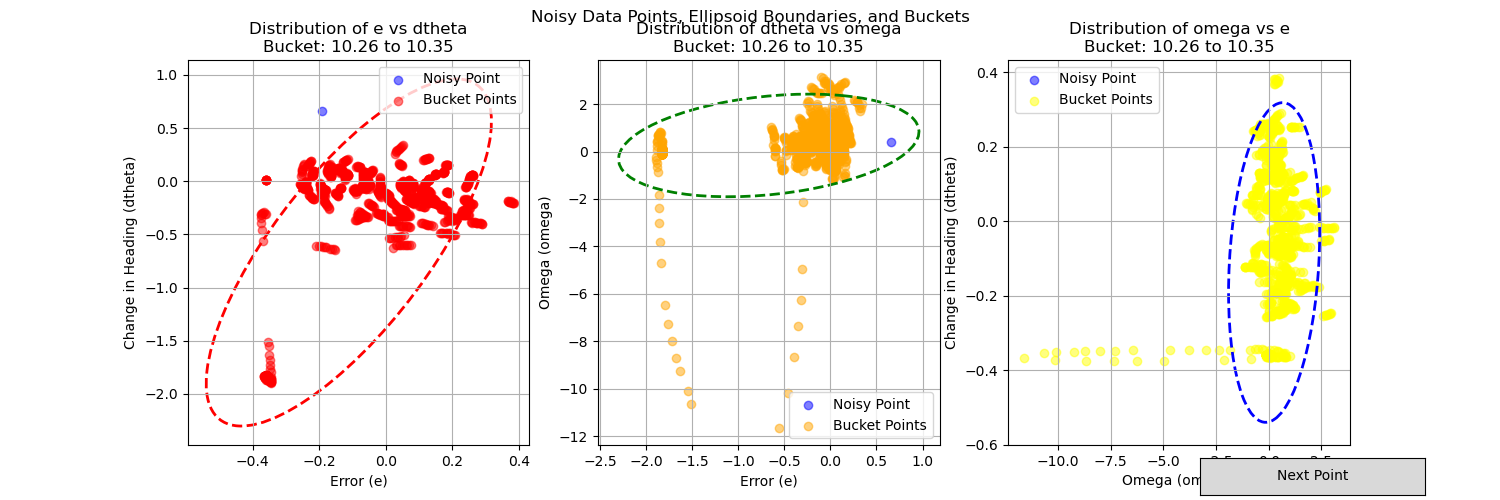

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Button
from matplotlib.patches import Ellipse

class InteractivePointPlot:
    def __init__(self, filtered_data, added_data, bucket_edges, bucket_centers, mean_e_per_bucket, mean_dtheta_per_bucket, std_e_per_bucket, std_dtheta_per_bucket, mean_omega_per_bucket, std_omega_per_bucket, e_sorted, dtheta_sorted, s_sorted, omega_sorted):
        self.filtered_data = filtered_data
        self.added_data = added_data
        self.bucket_edges = bucket_edges
        self.bucket_centers = bucket_centers
        self.mean_e_per_bucket = mean_e_per_bucket
        self.mean_dtheta_per_bucket = mean_dtheta_per_bucket
        self.std_e_per_bucket = std_e_per_bucket
        self.std_dtheta_per_bucket = std_dtheta_per_bucket
        self.e_sorted = e_sorted
        self.dtheta_sorted = dtheta_sorted
        self.s_sorted = s_sorted
        self.omega_sorted = omega_sorted
        self.mean_omega_per_bucket = mean_omega_per_bucket
        self.std_omega_per_bucket = std_omega_per_bucket

        self.current_trajectory_idx = 0  # Start from the first trajectory
        self.current_point_idx = 0  # Start from the first point in the trajectory

        # Get the list of all trajectory keys
        self.traj_keys = list(self.added_data.keys())
        
        # Create the figure with 1x3 grid layout for subplots
        self.fig, self.axs = plt.subplots(1, 3, figsize=(15, 5))
        self.fig.suptitle("Noisy Data Points, Ellipsoid Boundaries, and Buckets")
        self.axs[0].set_xlabel("Error (e)")
        self.axs[0].set_ylabel("Change in Heading (dtheta)")
        self.axs[1].set_xlabel("Error (e)")
        self.axs[1].set_ylabel("Omega (omega)")
        self.axs[2].set_xlabel("Omega (omega)")
        self.axs[2].set_ylabel("Change in Heading (dtheta)")
        
        for ax in self.axs:
            ax.grid(True)

        # Add a button to move to the next point
        self.ax_button = plt.axes([0.8, 0.01, 0.15, 0.075])  # Position of button
        self.button = Button(self.ax_button, "Next Point")
        self.button.on_clicked(self.next_point)

        # Initial plot for the first point
        self.plot_next_point()


    def plot_next_point(self):
        # Clear previous plots in all axes
        for ax in self.axs:
            ax.clear()
        
        # Reset the axis labels and grid
        self.axs[0].set_xlabel("Error (e)")
        self.axs[0].set_ylabel("Change in Heading (dtheta)")
        self.axs[1].set_xlabel("Error (e)")
        self.axs[1].set_ylabel("Omega (omega)")
        self.axs[2].set_xlabel("Omega (omega)")
        self.axs[2].set_ylabel("Change in Heading (dtheta)")
        
        for ax in self.axs:
            ax.grid(True)

        # Get the current trajectory and point
        traj_key = self.traj_keys[self.current_trajectory_idx]
        trajectory = self.added_data[traj_key]

        # Get the current noisy data point
        noisy_e = trajectory['e'][self.current_point_idx]
        noisy_dtheta = trajectory['dtheta'][self.current_point_idx]
        noisy_omega = trajectory['omega'][self.current_point_idx]

        # Get the corresponding bucket statistics
        s_value = trajectory['s'][self.current_point_idx]
        bucket_index = np.digitize(s_value, self.bucket_edges) - 1
        if bucket_index >= len(self.bucket_centers):
            bucket_index = len(self.bucket_centers) - 1

        # Find which points are in the current bucket
        bucket_start = self.bucket_edges[bucket_index]
        bucket_end = self.bucket_edges[bucket_index + 1]
        in_bucket = (self.s_sorted >= bucket_start) & (self.s_sorted < bucket_end)

        bucket_dtheta = self.dtheta_sorted[in_bucket]
        bucket_e = self.e_sorted[in_bucket]
        bucket_omega = self.omega_sorted[in_bucket]

        cov_matrix_ed = np.cov(bucket_e, bucket_dtheta)
        cov_matrix_do = np.cov(bucket_dtheta, bucket_omega)
        cov_matrix_oe = np.cov(bucket_omega, bucket_e)

        # Compute the eigenvalues and eigenvectors for each pair
        eigvals_ed, eigvecs_ed = np.linalg.eig(cov_matrix_ed)
        eigvals_do, eigvecs_do = np.linalg.eig(cov_matrix_do)
        eigvals_oe, eigvecs_oe = np.linalg.eig(cov_matrix_oe)

        # Calculate the standard deviations (square root of the eigenvalues)
        stds_ed = np.sqrt(eigvals_ed)
        stds_do = np.sqrt(eigvals_do)
        stds_oe = np.sqrt(eigvals_oe)

        # Compute the angles of the ellipses from the eigenvectors
        angle_ed = np.arctan2(eigvecs_ed[1, 0], eigvecs_ed[0, 0]) * 180 / np.pi
        angle_do = np.arctan2(eigvecs_do[1, 0], eigvecs_do[0, 0]) * 180 / np.pi
        angle_oe = np.arctan2(eigvecs_oe[1, 0], eigvecs_oe[0, 0]) * 180 / np.pi

        # Create the ellipses
        ellipse_ed = Ellipse(xy=(np.mean(bucket_e), np.mean(bucket_dtheta)),
                            width=4 * stds_ed[0], height=4 * stds_ed[1],
                            angle=angle_ed, edgecolor='red', facecolor='none', linestyle='--', linewidth=2)

        ellipse_do = Ellipse(xy=(np.mean(bucket_dtheta), np.mean(bucket_omega)),
                            width=4 * stds_do[0], height=4 * stds_do[1],
                            angle=angle_do, edgecolor='green', facecolor='none', linestyle='--', linewidth=2)

        ellipse_oe = Ellipse(xy=(np.mean(bucket_omega), np.mean(bucket_e)),
                            width=4 * stds_oe[0], height=4 * stds_oe[1],
                            angle=angle_oe, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2)

        # Plot for e vs dtheta
        self.axs[0].scatter(noisy_e, noisy_dtheta, color='blue', alpha=0.5, label="Noisy Point")
        self.axs[0].scatter(bucket_e, bucket_dtheta, color='red', alpha=0.5, label="Bucket Points")
        self.axs[0].add_patch(ellipse_ed)
        self.axs[0].set_title(f'Distribution of e vs dtheta\nBucket: {bucket_start:.2f} to {bucket_end:.2f}')
        self.axs[0].legend()

        # Plot for dtheta vs omega
        self.axs[1].scatter(noisy_dtheta, noisy_omega, color='blue', alpha=0.5, label="Noisy Point")
        self.axs[1].scatter(bucket_dtheta, bucket_omega, color='orange', alpha=0.5, label="Bucket Points")
        self.axs[1].add_patch(ellipse_do)
        self.axs[1].set_title(f'Distribution of dtheta vs omega\nBucket: {bucket_start:.2f} to {bucket_end:.2f}')
        self.axs[1].legend()

        # Plot for omega vs e
        self.axs[2].scatter(noisy_omega, noisy_e, color='blue', alpha=0.5, label="Noisy Point")
        self.axs[2].scatter(bucket_omega, bucket_e, color='yellow', alpha=0.5, label="Bucket Points")
        self.axs[2].add_patch(ellipse_oe)
        self.axs[2].set_title(f'Distribution of omega vs e\nBucket: {bucket_start:.2f} to {bucket_end:.2f}')
        self.axs[2].legend()

        # Redraw the plot
        self.fig.canvas.draw()

    def next_point(self, event):
        # Increment the point index for the current trajectory
        self.current_point_idx += 1

        # If we are at the last point of the current trajectory, move to the next trajectory
        if self.current_point_idx >= len(self.added_data[self.traj_keys[self.current_trajectory_idx]]['e']):
            self.current_point_idx = 0  # Reset to the first point of the current trajectory
            self.current_trajectory_idx += 1  # Move to the next trajectory

        # If we are at the last trajectory, loop back to the first trajectory
        if self.current_trajectory_idx >= len(self.traj_keys):
            self.current_trajectory_idx = 0

        # Plot the next point
        self.plot_next_point()

# Create the interactive plot instance
interactive_point_plot = InteractivePointPlot(
    data, added_data, bucket_edges, bucket_centers, mean_e_per_bucket, mean_dtheta_per_bucket, std_e_per_bucket, std_dtheta_per_bucket,
    mean_omega_per_bucket, std_omega_per_bucket, e_sorted, dtheta_sorted, s_sorted, omega_sorted
)
plt.show()


In [14]:


def convert_numpy_types(data):
    """
    Recursively traverses the data structure and:
    - Converts any NumPy scalars (e.g., np.float64, np.int32) to native Python types.
    - Converts any NumPy arrays to Python lists.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            data[key] = convert_numpy_types(value)  
    elif isinstance(data, list):
        for i, item in enumerate(data):
            data[i] = convert_numpy_types(item)
    elif isinstance(data, np.ndarray):  
        return data.tolist()
    elif isinstance(data, np.generic): 
        return data.item()  
    else:
        return data
    
    return data  

def check_numpy_types(data):
    if isinstance(data, dict):
        for key, value in data.items():
            check_numpy_types(value)  
    elif isinstance(data, list):
        for item in data:
            check_numpy_types(item)  
    elif isinstance(data, np.ndarray):
        print(f"Found NumPy array: {data}")
    elif isinstance(data, np.generic):
        print(f"Found NumPy scalar: {data}")
    else:
        pass

convert_numpy_types(filtered_data)
check_numpy_types(filtered_data)

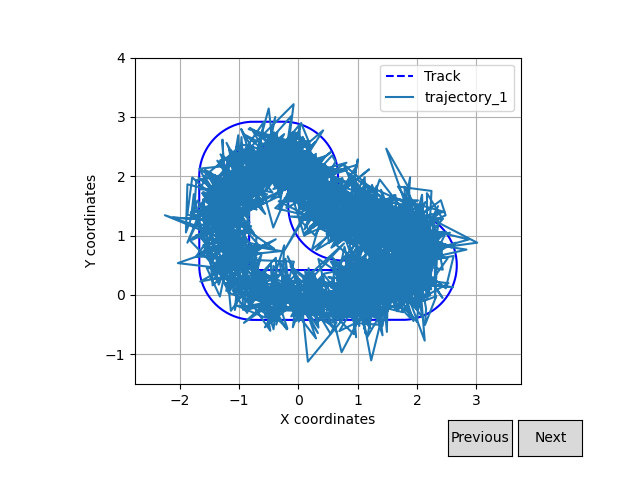

In [15]:
%matplotlib widget

def update_trajectory(label):
    ax.clear()
    plot_track(fig, ax, track_shape_data)
    i = 0
    if label in filtered_data:
        # Plot the individual points without connecting them
        ax.scatter(added_data[label]['x'], added_data[label]['y'], label=label, color='b')
        
        # Add arrows to indicate the steering angle
        for i in range(len(added_data[label]['x'])):
            x = added_data[label]['x'][i]
            y = added_data[label]['y'][i]
            heading_angle = added_data[label]['heading_angle'][i]
            steering_angle = added_data[label]['steering'][i]

            # Determine the direction of the arrow based on heading angle and steering angle
            arrow_length = 0.3
            dx = arrow_length * np.cos(heading_angle)
            dy = arrow_length * np.sin(heading_angle)

            dx_steer = arrow_length * np.cos(heading_angle + steering_angle)
            dy_steer = arrow_length * np.sin(heading_angle + steering_angle)

            
            # Draw an arrow for the steering angle
            if i == 0:
                ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r', alpha=0.6, label='Heading')
                ax.quiver(x, y, dx_steer, dy_steer, angles='xy', scale_units='xy', scale=1, color='g', alpha=0.6, label='Steering')
            else:
                ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r', alpha=0.6)
                ax.quiver(x, y, dx_steer, dy_steer, angles='xy', scale_units='xy', scale=1, color='g', alpha=0.6)
                
            i += 1
        

    ax.legend()
    plt.draw()
class Index:
    def __init__(self, traj_labels):
        self.idx = 0
        self.traj_labels = traj_labels

    def next(self, event):
        self.idx = (self.idx + 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

    def prev(self, event):
        self.idx = (self.idx - 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)

track_shape_data['track']['xCoords'] = np.array(track_shape_data['track']['xCoords']) + track_shape_data['track']['x_init']
track_shape_data['track']['yCoords'] = np.array(track_shape_data['track']['yCoords']) + track_shape_data['track']['y_init']

plot_track(fig, ax, track_shape_data)

initial_traj = list(filtered_data.keys())[0]
ax.plot(added_data[initial_traj]['x'], added_data[initial_traj]['y'], label=initial_traj)
ax.legend()

axprev = plt.axes([0.7, 0.05, 0.1, 0.075]) 
axnext = plt.axes([0.81, 0.05, 0.1, 0.075]) 

traj_labels = list(added_data.keys())
callback = Index(traj_labels)
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

# Show the plot
plt.show()


In [16]:

filtered_data_frame = pd.DataFrame(filtered_data)

filtered_data_frame.to_feather('Obtained Model Data/noisy_trajectories_Kdd05_wo_ellipse.feather')


added_data_df = pd.DataFrame(added_data)

added_data_df.to_feather('Obtained Model Data/added_data_low_noise_Kdd05_wo_ellipse.feather')